# Customer Churn Factors


## Imports

In [73]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import acquire
import prepare

## Acquire

* Accquired data from noether sequal server
* data obtained 1/2/2023
* 7043 rows by 24 columns before cleaning
* Each row represents a customer
* Each column represents a demograhic or service type information


In [2]:
telco = acquire.get_telco_data() #acquiring data from server and assigning it to a variable


In [3]:
telco.head() # a brief look at the data

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,No,2,Yes,2,65.6,593.3,No,DSL,One year,Mailed check
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,Yes,1,No,2,59.9,542.4,No,DSL,Month-to-month,Mailed check
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,No,1,Yes,1,73.9,280.85,Yes,Fiber optic,Month-to-month,Electronic check
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,Yes,1,Yes,1,98.0,1237.85,Yes,Fiber optic,Month-to-month,Electronic check
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,No,1,Yes,2,83.9,267.4,Yes,Fiber optic,Month-to-month,Mailed check


In [4]:
DSL = np.array([459, 1962])
Fiber_optic = np.array([1297, 1799])
nointernet = np.array([113, 1413])

# Explore
* Explore data in search of drivers of churn
   * Answer the following initial questions
       * How often does churn occur?
       * Do total_charges affect churn?
       * Do monthly_charges affect churn?
       * Does contract_type affect churn?
       * Does having online_security affect churn?
       * Does a customer's internet service type affect churn?

In [5]:
churned = telco[telco['churn'] == 'Yes'] #1869 count of customers that have churned

In [6]:
churned = telco[telco['churn'] == 'No'] #5174 cound of customers that have not churned

In [7]:
y = np.array([1869, 5174])
mylabels = ['churned', 'not churned']

## How often does churn occur?

Text(0.5, 1.0, 'churn rate')

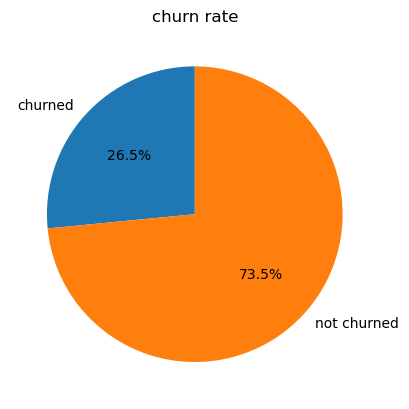

In [113]:
plt.pie(y, labels = mylabels, startangle=90, autopct='%1.1f%%')
plt.title('churn rate')

It is shown that roughly 26% of customers will churn

## Does internet service type affect churn?

In [9]:
DSL = np.array([459, 1962])
Fiber_optic = np.array([1297, 1799])
nointernet = np.array([113, 1413])

Text(0.5, 1.0, 'DSL Churn Rate')

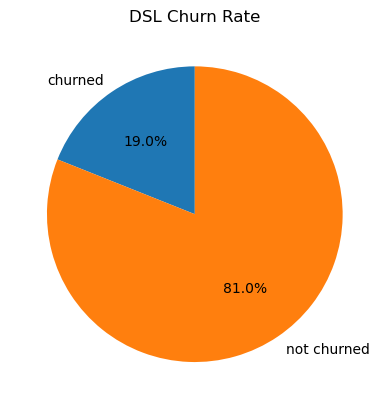

In [10]:
plt.pie(DSL, labels = mylabels, startangle=90, autopct='%1.1f%%')
plt.title('DSL Churn Rate')

Text(0.5, 1.0, 'Fiber Optic Churn Rate')

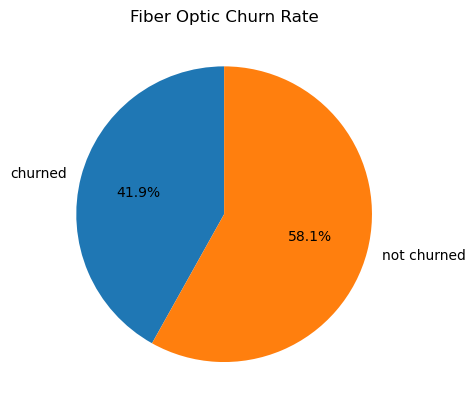

In [11]:
plt.pie(Fiber_optic, labels = mylabels, startangle=90, autopct='%1.1f%%')
plt.title('Fiber Optic Churn Rate')



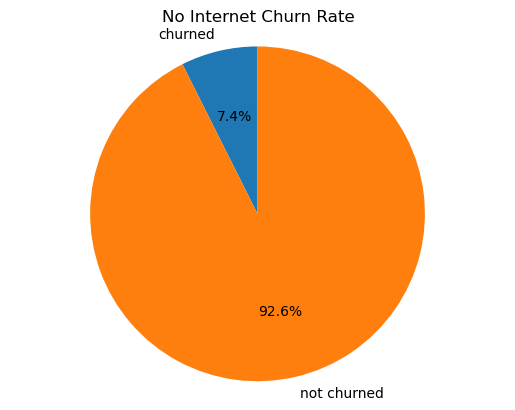

In [12]:

plt.pie(nointernet,labels=mylabels, startangle=90, autopct='%1.1f%%')
plt.title("No Internet Churn Rate")
plt.axis('equal')

plt.show()

#### it appears as though customers with Fibic optic Internet are more likely to churn

## Prepare
* Removed columns that did not contain useful information
* Checked for nulls in the data and removed them
* Eliminated rows that did have a space as a value in their total_charges column
* Changed total_charges column object to float
* Added dummy variables for categorical variables
* Split data into train, validate and test (approx. 60/25/15), stratifying on 'churn'
* Scaled continuous variable
* Outliers have not been removed for this iteration of the project

In [13]:
telco = prepare.prep_classification_project_chi(telco) #function prepares data

## A quick look at the data


In [14]:
telco.head() #prints the first 5 rows of the cleaned dataset

,online_security,churn,internet_service_type,scaled_total,scaled_monthly,online_security_No internet service,online_security_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year
0,No,No,DSL,0.068315,0.552421,0,0,0,0,1,0
1,No,No,DSL,0.062454,0.504421,0,0,0,0,0,0
2,No,Yes,Fiber optic,0.032338,0.622316,0,0,1,0,0,0
3,No,Yes,Fiber optic,0.142531,0.825263,0,0,1,0,0,0
4,No,Yes,Fiber optic,0.030789,0.706526,0,0,1,0,0,0


## A summary of the data

In [15]:
telco.describe() #statistical description of each of the numerical value columns

,scaled_total,scaled_monthly,online_security_No internet service,online_security_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.262908,0.545669,0.216155,0.286547,0.440273,0.216155,0.209329,0.239619
std,0.261004,0.253356,0.411650,0.452180,0.496455,0.411650,0.406858,0.426881
min,0.002165,0.153684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.046224,0.299684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.160910,0.592421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.436940,0.756737,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#splits data into train, validate, and test variables
train, test = train_test_split(telco, test_size=.2, random_state=123, stratify=telco.churn)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.churn)

In [17]:
#verifying that data was split correctly 
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3937, 11)
validate -> (1688, 11)
test -> (1407, 11)


In [18]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3937 entries, 5919 to 4192
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   online_security                      3937 non-null   object 
 1   churn                                3937 non-null   object 
 2   internet_service_type                3937 non-null   object 
 3   scaled_total                         3937 non-null   float64
 4   scaled_monthly                       3937 non-null   float64
 5   online_security_No internet service  3937 non-null   uint8  
 6   online_security_Yes                  3937 non-null   uint8  
 7   internet_service_type_Fiber optic    3937 non-null   uint8  
 8   internet_service_type_None           3937 non-null   uint8  
 9   contract_type_One year               3937 non-null   uint8  
 10  contract_type_Two year               3937 non-null   uint8  
dtypes: float64(2), object(3), u

### I will now perform a chi squared test to see if there exists a relationship between internet service type and churn

In [19]:
# created cross tab for internet service type vs churn
observed = pd.crosstab(train.internet_service_type, train.churn)

In [20]:
# Performing chi squared tests
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [21]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')

Observed Values

[[1101  247]
 [ 987  735]
 [ 803   64]]
---
Expected Values

[[ 989  358]
 [1264  457]
 [ 636  230]]
---

chi^2 = 439.7661
p     = 0.0000


### according to the test, we can say that there likely is a relationship between internet service type and churn

## I will now perform a chi squared test to see if there exists a relationship between churn and having online_security

In [22]:
#defining variable as crosstab between churn and online_security
observed = pd.crosstab(train.online_security, train.churn)

In [23]:
# Performing chi squared tests
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [24]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')

Observed Values

[[1099  819]
 [ 803   64]
 [ 989  163]]
---
Expected Values

[[1408  509]
 [ 636  230]
 [ 845  306]]
---

chi^2 = 510.5206
p     = 0.0000


## According to our model, there does exist a relationship between online security and churn

In [84]:
#calling model
seed = 42
clf = DecisionTreeClassifier(max_depth = 3, random_state = 42)

In [85]:
telco = acquire.get_telco_data() #restarting getting the data

In [86]:
telco = prepare.prep_classification_project_tree(telco) #preparing data for decision tree model

In [87]:
train, test = train_test_split(telco, test_size=.2, random_state=123, stratify=telco.churn)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.churn)
#splitting data

In [91]:
# preparing variables to fit into decision tree model statifying churn
x_train = train.drop(columns = ['churn'])
y_train = train['churn']

x_val = validate.drop(columns = ['churn'])
y_val = validate['churn']

x_test = test.drop(columns = ['churn'])
y_test = test['churn']

In [92]:
train

,churn,scaled_total,scaled_monthly,online_security_No internet service,online_security_Yes,internet_service_type_Fiber optic,internet_service_type_None,contract_type_One year,contract_type_Two year
5919,No,0.495026,0.598737,0,1,0,0,1,0
1915,No,0.694196,0.719579,0,1,1,0,1,0
5054,No,0.101620,0.216842,1,0,0,1,0,0
2355,No,0.002211,0.161684,1,0,0,1,0,0
6279,No,0.121580,0.454737,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
394,No,0.238664,0.749053,0,0,1,0,0,0
3763,Yes,0.122588,0.844211,0,1,1,0,0,0
3444,No,0.063951,0.212632,1,0,0,1,0,1
1002,No,0.224461,0.750316,0,0,1,0,0,0


In [93]:
#fitting model
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

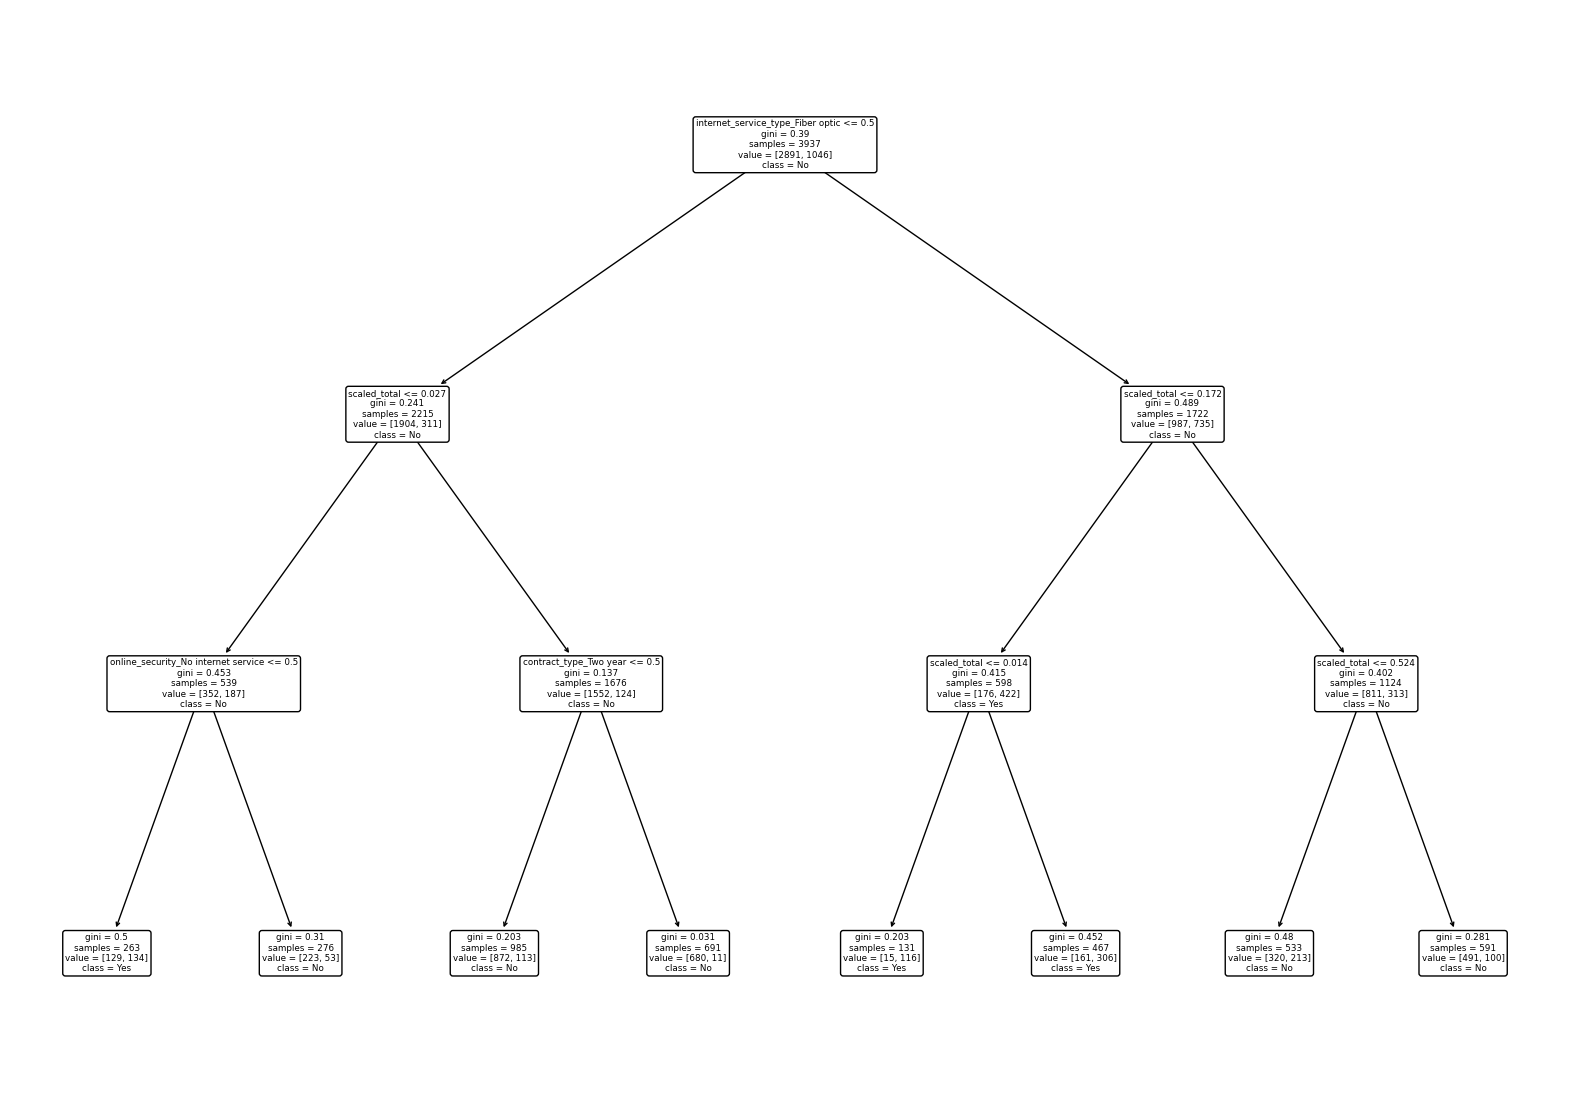

In [94]:
#showing model
plt.figure(figsize=(20, 14))
plot_tree(clf, feature_names= x_train.columns, class_names = np.array(clf.classes_).astype('str').tolist(), rounded = True)
plt.show()

In [77]:
#making predictions
y_pred = clf.predict(x_train)
y_pred[0:100]

array(['No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No',
       'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes',
       'Yes', 'No', 'Yes', 'No', 'No'], dtype=object)

In [78]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.89      0.87      2891
         Yes       0.65      0.53      0.58      1046

    accuracy                           0.80      3937
   macro avg       0.74      0.71      0.72      3937
weighted avg       0.79      0.80      0.79      3937



In [82]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = clf.predict(x_val)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          No       0.83      0.87      0.85      1239
         Yes       0.59      0.50      0.54       449

    accuracy                           0.77      1688
   macro avg       0.71      0.69      0.70      1688
weighted avg       0.76      0.77      0.77      1688



In [36]:
# Import your prepare function and use it to clean your data here

### The Decision tree model is OK. It has 80% accuracy but has relatively low precision. I would prefer a model that has higher precision. than 60%. There may be other models that are better.

# Random Forest model

In [95]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [96]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [97]:
RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)


RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [98]:
print(rf.feature_importances_)
y_pred = rf.predict(x_train)


[0.22993951 0.08896491 0.05886807 0.06792464 0.2232545  0.06116931
 0.07576883 0.19411022]


In [99]:
y_pred_proba = rf.predict_proba(x_train)

In [100]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

          No       0.81      0.95      0.87      2891
         Yes       0.72      0.38      0.50      1046

    accuracy                           0.80      3937
   macro avg       0.77      0.66      0.69      3937
weighted avg       0.79      0.80      0.77      3937



In [106]:
y_pred = rf.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          No       0.80      0.92      0.86      1239
         Yes       0.62      0.35      0.45       449

    accuracy                           0.77      1688
   macro avg       0.71      0.64      0.65      1688
weighted avg       0.75      0.77      0.75      1688



### The Random Forest model is a little better than the decision tree model.

# KNN model

In [103]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_train)
y_pred_proba = knn.predict_proba(x_train)

In [104]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.87      0.92      0.89      2891
         Yes       0.74      0.61      0.67      1046

    accuracy                           0.84      3937
   macro avg       0.80      0.77      0.78      3937
weighted avg       0.83      0.84      0.83      3937



In [107]:
y_pred = knn.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          No       0.82      0.86      0.84      1239
         Yes       0.56      0.50      0.53       449

    accuracy                           0.76      1688
   macro avg       0.69      0.68      0.68      1688
weighted avg       0.75      0.76      0.76      1688



## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influanced your analysis
* Remember to split your data before exploring how differint variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a vizualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

The following empty code block is here to represent the countless questions, visualizations, and statistical tests 
that did not make your final report. Data scientist often create a myriad of questions, vizualizations 
and statistical tests that do not make it into the final notebook. This is okay and expected. Remember 
that shotgun approches to your data such as using pair plots to look at the relationships of each feature 
pair are a great way to explore your data, but they have no place in your final report. 
**Your final report is about showing your findings, not showing your work!**

## You may use this as a templet for how to ask and answer each question:

### 1) Question about the data
* ask a question about the data for which you got a meaningful result.

### 2) Vizualization of the data answering the question

* vizualizations should be acompanied by take-aways telling the reader exaclty what you want them to get from the chart
* Good take-aways often make for good chart titles. Try to use your chart title instead of bullet points.

### 3) Statistical test
* Be sure you are using the correct statistical test for the type of variables you are testing
* be sure that you are not violating any of the asumptions for the statistical test you are choosing
* your notebook should run and produce the results of the test you are using (This may be done through imports)
* Include an introduction to the kind of test you are doing
* Include the Ho and Ha for the test
* Include the alpha you are using
* Include the readout of the p-value for the test
* Interpret the results of the test in natural language 

### 4) Answer to the question
* Answer the question that you posed of the data by refering to the chart and statistical test (if you used one).
* if question relates to drivers, explain why the feature in question would/wouldn't make a good driver.

## Exploration Summery
* after your explore section before you start modeling provide a summary of your findings in Explore
* Include a summery of your take-aways from Explore including answers to the questions you asked
* Include a summery of the features you examined and weather or not you will be going to Modeling with each feature and why
* It is important to note which features will be going into your model so the reader knows what features you will be modeling on


## Modeling

* Explain how you will be evauating your models. Be sure to include the evaluation metric you will be using and why you have chosen it

### Baseline 
* create a baseline and briefly explain how it was calculated 

In [37]:
# If your baseline comes from a model run the model here and show it's results

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Tipically students will show the top models they are able to generate for three differint model types

## You may use this as a templet for how to introduce your models:

### Model Type

In [38]:
# code that runs the best model in that model type (this mad be imported from a module)

Print out of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as yout best model and explain why you have chosen it
* Explain that you will now run your final model on test data to guage how it will perform on unseen data


In [39]:
# Code that runs the best overall model on test data (this may be imported from a module)

Print out of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpritation of how the models test score compares to the baseline and weather you would recomend this model for production

## Conclution

### Summery
* summerize you findings and answer the questions you brought up in explore 
* summerize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Nest Steps are what you as a Data Scientist would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. this is ture for any and all code blocks even if you are using a function to import the code**

**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist your job is not only to make discoveries but to effectivly communicate them as well. This means documintation is a critical part of your job.**